# 🔋 Phase 2b: Ekstraksi Kapasitas & True OCV (Dataset Final 1 Siklus Murni)
**Tujuan:** Mengekstrak nilai Kapasitas Sejati ($Q_{25}$), Efisiensi Coulombic ($\eta$), dan kurva True OCV menggunakan data 1 siklus murni: *Discharge Residual -> Cas 100% -> Kuras 0%*.

**Dataset:** `DCC 2.5V - CCV 3.65 - DCC 2.5V.csv`

📊 HASIL ANALISIS KAPASITAS & EFISIENSI (FINAL)
Kapasitas Aktual Baterai (Q25) : 20.7986 Ah
Coulombic Efficiency (Ah)      : 99.68 %
Energy Efficiency (Wh)         : 96.38 %


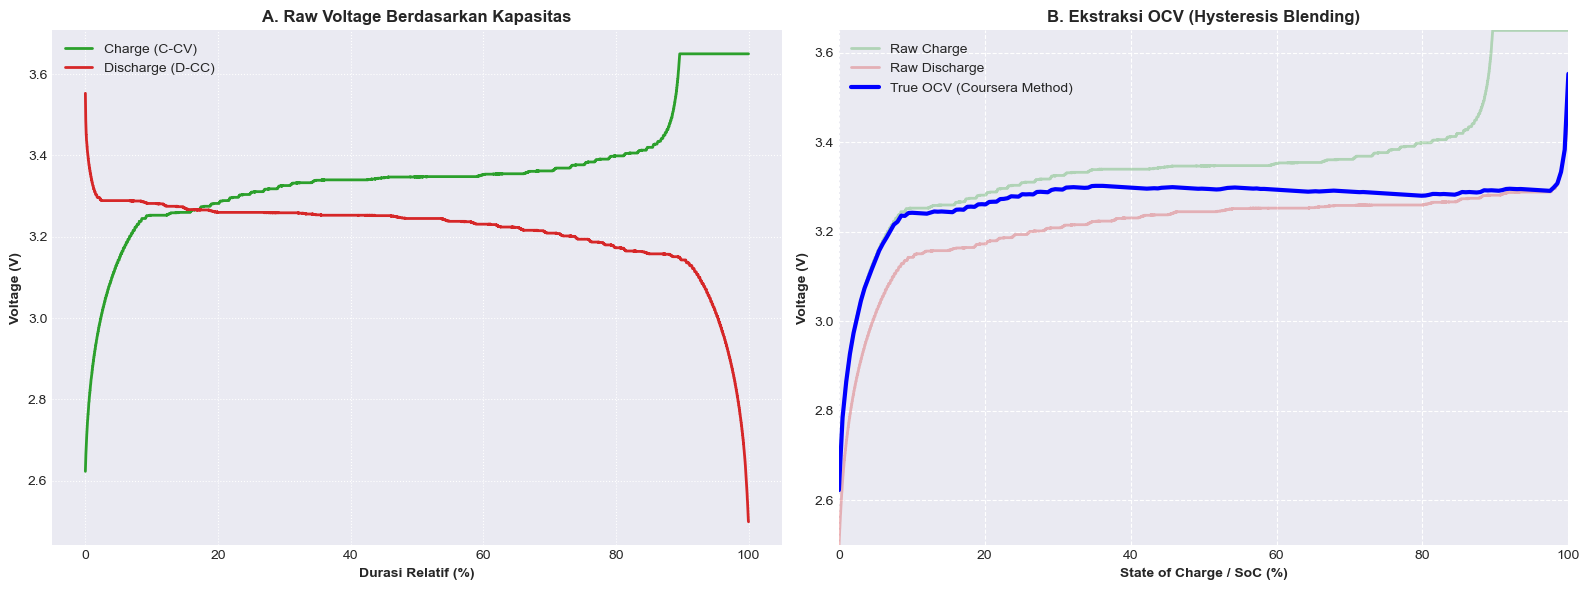

✅ File CSV 'ocv_lookup_table_b.csv' FINAL BERHASIL DISIMPAN!


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 6)

# =========================================================
# 1. LOAD DATA DAN DETEKSI BLOK (INTEGRASI WAKTU)
# =========================================================
def load_zke_data(filepath):
    skip_rows = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if "Time(S)" in line:
                skip_rows = i
                break
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df.columns = [col.strip() for col in df.columns]
    return df

df_raw = load_zke_data("DCC 2.5V - CCV 3.65 - DCC 2.5V.csv")
df_raw['dt'] = df_raw['Time(S)'].diff().fillna(0)

# Deteksi Fase Charge dan Discharge
df_raw['Is_Active'] = df_raw['Cur(A)'] > 0.05
df_raw['Block'] = (df_raw['Is_Active'] != df_raw['Is_Active'].shift(1)).cumsum()
active_blocks = df_raw[df_raw['Is_Active']]['Block'].unique()

# Sesuai urutan tes ZKETECH:
# Block 1 = Residual Discharge
# Block 2 = C-CV Charge Utama
# Block 3 = D-CC Discharge Utama
ind_Chg = df_raw[df_raw['Block'] == active_blocks[1]].index.tolist()
ind_Dis = df_raw[df_raw['Block'] == active_blocks[2]].index.tolist()

# Hitung Kapasitas & Efisiensi via Integrasi Manual
Ah_Chg = (df_raw.loc[ind_Chg, 'Cur(A)'] * df_raw.loc[ind_Chg, 'dt']).sum() / 3600
Ah_Dis = (df_raw.loc[ind_Dis, 'Cur(A)'] * df_raw.loc[ind_Dis, 'dt']).sum() / 3600

Wh_Chg = (df_raw.loc[ind_Chg, 'Cur(A)'] * df_raw.loc[ind_Chg, 'Vol(V)'] * df_raw.loc[ind_Chg, 'dt']).sum() / 3600
Wh_Dis = (df_raw.loc[ind_Dis, 'Cur(A)'] * df_raw.loc[ind_Dis, 'Vol(V)'] * df_raw.loc[ind_Dis, 'dt']).sum() / 3600

print("="*60)
print("📊 HASIL ANALISIS KAPASITAS & EFISIENSI (FINAL)")
print("="*60)
print(f"Kapasitas Aktual Baterai (Q25) : {Ah_Dis:.4f} Ah")
print(f"Coulombic Efficiency (Ah)      : {(Ah_Dis/Ah_Chg)*100:.2f} %")
print(f"Energy Efficiency (Wh)         : {(Wh_Dis/Wh_Chg)*100:.2f} %")
print("="*60)

# =========================================================
# 2. EKSTRAKSI TRUE OCV (METODE COURSERA BLENDING)
# =========================================================
# Hitung Voltage Drop (IR)
IR1Ca = df_raw['Vol(V)'].iloc[ind_Chg[0]] - df_raw['Vol(V)'].iloc[ind_Chg[0]-1]
IR2Ca = df_raw['Vol(V)'].iloc[ind_Chg[-1]] - df_raw['Vol(V)'].iloc[ind_Chg[-1]+1]

IR1Da = df_raw['Vol(V)'].iloc[ind_Dis[0]-1] - df_raw['Vol(V)'].iloc[ind_Dis[0]]
# Safeguard jika ind_Dis menyentuh akhir baris file
if ind_Dis[-1] + 1 < len(df_raw):
    IR2Da = df_raw['Vol(V)'].iloc[ind_Dis[-1]+1] - df_raw['Vol(V)'].iloc[ind_Dis[-1]]
else:
    IR2Da = 0.0

IR1C = min(IR1Ca, 2 * IR2Da); IR2C = min(IR2Ca, 2 * IR1Da)
IR1D = min(IR1Da, 2 * IR2Ca); IR2D = min(IR2Da, 2 * IR1Ca)

# Koreksi Hysteresis
blend_C = np.linspace(0, 1, len(ind_Chg))
chgV = df_raw['Vol(V)'].iloc[ind_Chg].values - (IR1C + (IR2C - IR1C) * blend_C)
chgZ = np.linspace(0, 1, len(ind_Chg)) 

blend_D = np.linspace(0, 1, len(ind_Dis))
disV = df_raw['Vol(V)'].iloc[ind_Dis].values + (IR1D + (IR2D - IR1D) * blend_D)
disZ = np.linspace(1, 0, len(ind_Dis)) 

f_chg = interp1d(chgZ, chgV, fill_value="extrapolate")
f_dis = interp1d(disZ, disV, fill_value="extrapolate")
deltaV50 = f_chg(0.5) - f_dis(0.5)

ind_chg_half = np.where(chgZ < 0.5)[0]
vChg = chgV[ind_chg_half] - (chgZ[ind_chg_half] * deltaV50)
zChg = chgZ[ind_chg_half]

ind_dis_half = np.where(disZ > 0.5)[0]
vDis = np.flip(disV[ind_dis_half] + ((1 - disZ[ind_dis_half]) * deltaV50))
zDis = np.flip(disZ[ind_dis_half])

z_combined = np.concatenate((zChg, zDis))
v_combined = np.concatenate((vChg, vDis))
sort_idx = np.argsort(z_combined)

SOC_out = np.linspace(0, 1, 200)
f_rawocv = interp1d(z_combined[sort_idx], v_combined[sort_idx], kind='linear', fill_value="extrapolate")
True_OCV = f_rawocv(SOC_out)

# =========================================================
# 3. VISUALISASI FINAL UNTUK SKRIPSI
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(np.linspace(0, 100, len(ind_Chg)), df_raw['Vol(V)'].iloc[ind_Chg].values, color='tab:green', linewidth=2, label='Charge (C-CV)')
ax1.plot(np.linspace(0, 100, len(ind_Dis)), df_raw['Vol(V)'].iloc[ind_Dis].values, color='tab:red', linewidth=2, label='Discharge (D-CC)')
ax1.set_title('A. Raw Voltage Berdasarkan Kapasitas', fontweight='bold')
ax1.set_xlabel('Durasi Relatif (%)', fontweight='bold')
ax1.set_ylabel('Voltage (V)', fontweight='bold')
ax1.legend()
ax1.grid(True, linestyle=':')

ax2.plot(chgZ*100, df_raw['Vol(V)'].iloc[ind_Chg].values, color='tab:green', alpha=0.3, linewidth=2, label='Raw Charge')
ax2.plot(disZ*100, df_raw['Vol(V)'].iloc[ind_Dis].values, color='tab:red', alpha=0.3, linewidth=2, label='Raw Discharge')
ax2.plot(SOC_out * 100, True_OCV, color='blue', linewidth=3, linestyle='-', label='True OCV (Coursera Method)')

ax2.set_title('B. Ekstraksi OCV (Hysteresis Blending)', fontweight='bold')
ax2.set_xlabel('State of Charge / SoC (%)', fontweight='bold')
ax2.set_ylabel('Voltage (V)', fontweight='bold')
ax2.set_xlim(0, 100); ax2.set_ylim(2.5, 3.65)
ax2.legend()
ax2.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

# Simpan CSV OCV Master Final
pd.DataFrame({'SoC': SOC_out, 'True_OCV': True_OCV}).to_csv('ocv_lookup_table_b.csv', index=False)
print("✅ File CSV 'ocv_lookup_table_b.csv' FINAL BERHASIL DISIMPAN!")